<a href="https://colab.research.google.com/github/HashimFadhan/DEEP_LEARNING/blob/main/Cats_VS_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import sklearn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from keras import callbacks
from keras.layers import Dense, Flatten, BatchNormalization, GlobalAveragePooling2D, Dropout, Input
from keras import Model
from keras.layers import  Conv2D, MaxPool2D, add
from keras.preprocessing import image
import random
import os
import zipfile

training_path = '/content/drive/MyDrive/Cat vs dog/training_set.zip'
test_path = '/content/drive/MyDrive/Cat vs dog/test_set.zip'
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 150
with zipfile.ZipFile(training_path, 'r') as zip_ref:
    zip_ref.extractall('/content/cat_vs_dog_data')

# Extract the test set
with zipfile.ZipFile(test_path, 'r') as zip_ref:
    zip_ref.extractall('/content/cat_vs_dog_data')


# Update the directory path in image_dataset_from_directory
# Removed an extra 'training_set' from the path
train_ds = keras.utils.image_dataset_from_directory(
    directory="/content/cat_vs_dog_data/training_set",  # Updated path
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.15,
    subset='training'
)

# Removed an extra 'test_set' from the path
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="/content/cat_vs_dog_data/test_set",  # Updated path
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42
)

# Removed an extra 'training_set' from the path
valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory="/content/cat_vs_dog_data/training_set",  # Updated path
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.15,
    subset='validation'
)

Found 8005 files belonging to 2 classes.
Using 6805 files for training.
Found 2023 files belonging to 2 classes.
Found 8005 files belonging to 2 classes.
Using 1200 files for validation.


In [9]:
cnt_imgs = 16  # we take 8 images for each class
# Correct the paths - removed the extra /cats and /dogs
cat_path = '/content/cat_vs_dog_data/training_set/cats'
dog_path = '/content/cat_vs_dog_data/training_set/dogs'
cat_imgs = os.listdir(cat_path)[:cnt_imgs]
dog_imgs = os.listdir(dog_path)[:cnt_imgs]

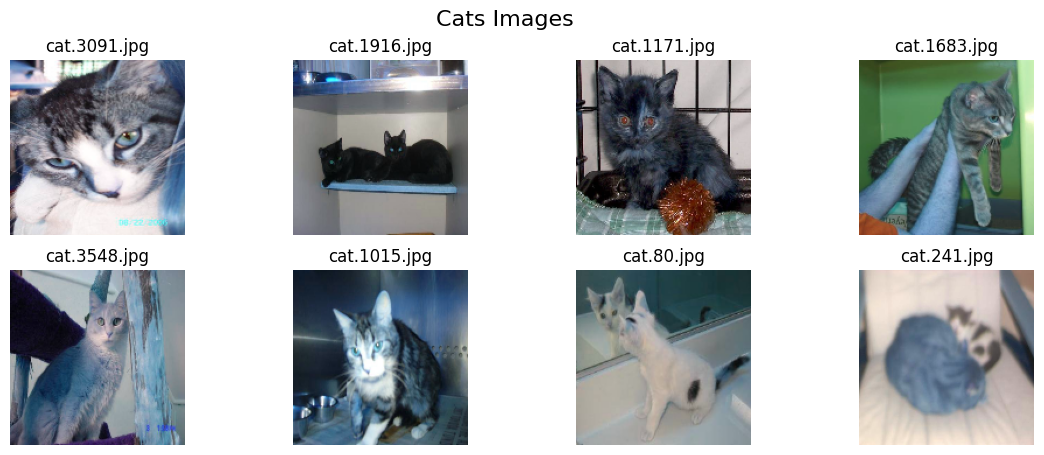

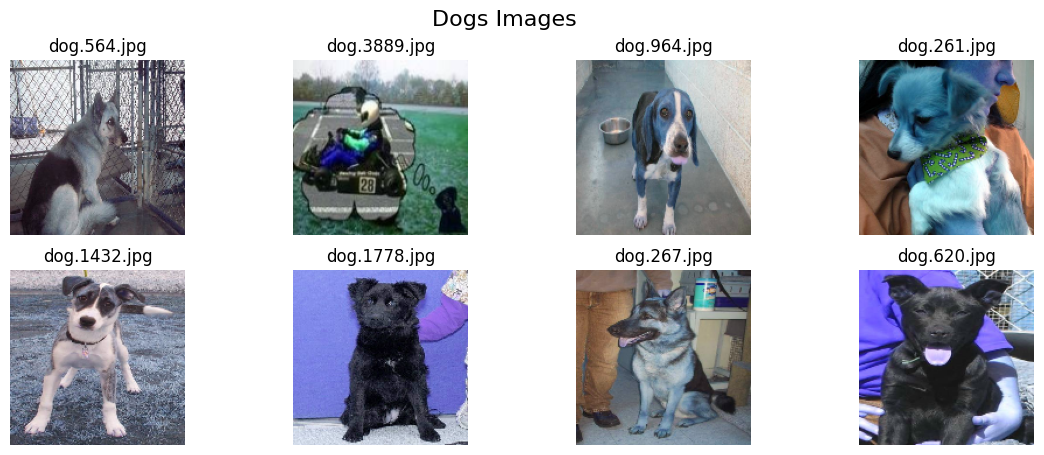

In [10]:

# Function to plot images for a specific category
def plot_images_for_category(category_path, category_name, num_images=8):
    image_files = os.listdir(category_path)[:num_images]
    image_paths = [os.path.join(category_path, file) for file in image_files]

    plt.figure(figsize=(14, 5))  # Adjust figure size if needed
    plt.suptitle(f"{category_name} Images", fontsize=16)  # Main title for category

    for i, img_path in enumerate(image_paths):
        plt.subplot(2, 4, i + 1)  # 2 rows, 4 columns
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, IMAGE_SIZE)
            plt.imshow(img)
            plt.title(os.path.basename(img_path))  # Title as filename
            plt.axis('off')
        else:
            print(f"Error: Could not load image at path: {img_path}")

    plt.show()

# Plot for cats
plot_images_for_category(cat_path, "Cats")

# Plot for dogs
plot_images_for_category(dog_path, "Dogs")

In [11]:
def check_cnt_label(label: str) -> int:
    """A function that should determine the number of objects of this
    class in the specified directories"""
    cnt_object = 0
    # Paths to the extracted data directories, not the zip files
    paths = ['/content/cat_vs_dog_data/training_set', '/content/cat_vs_dog_data/test_set']
    for path in paths:
        path += '/' + label  # Construct the path to the specific label folder
        cnt_object += len(os.listdir(path))  # Count the files in the label folder
    return cnt_object

CNT_CAT = check_cnt_label('cats')
CNT_DOG = check_cnt_label('dogs')

In [12]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Cats', 'Dogs'],
    y=[CNT_CAT, CNT_DOG],
    width=[0.4, 0.4]))

fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

In [13]:
rescale = Rescaling(scale=1.0 / 255)

train_ds = train_ds.map(lambda image, label: (rescale(image), label))

valid_ds  = valid_ds.map(lambda image, label: (rescale(image), label))

test_ds = test_ds.map(lambda image, label: (rescale(image), label))

EPOCHS = 35

In [ ]:
CALLBACKS = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=7, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=2, verbose=1, mode='auto')
]

inputs = Input(shape=(IMAGE_SIZE + (3,)))

x = Conv2D(32, (3, 3), activation='elu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='elu')(x)
block_1_output = MaxPool2D(pool_size=(3, 3))(x)

x = Conv2D(64, (3, 3), activation='elu', padding='same')(block_1_output)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
block_2_output = add([x, block_1_output])

x = Conv2D(64, (3, 3), activation='elu', padding='same')(block_2_output)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
block_3_output = add([x, block_2_output])

x = Conv2D(128, (3, 3), activation='elu')(block_3_output)
x = MaxPool2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='elu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs, output)
model.compile(metrics=['Accuracy'], loss='binary_crossentropy', optimizer='Adam')
history = model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=CALLBACKS)

Epoch 1/35
46/46 ━━━━━━━━━━━━━━━━━━━━ 1603s 35s/step - Accuracy: 0.5447 - loss: 0.8057 - val_Accuracy: 0.5033 - val_loss: 0.6954 - learning_rate: 0.0010
Epoch 2/35
19/46 ━━━━━━━━━━━━━━━━━━━━ 14:59 33s/step - Accuracy: 0.6085 - loss: 0.6523

In [ ]:
from google.colab import drive
drive.mount('/content/drive')